<a href="https://colab.research.google.com/github/sriksmachi/aimriscan/blob/main/style_transfer_using_cyclegan_brainmri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Style Transfer using GANs

## Problem Statement


MRI(Magnetic Resonance Imaging) brain has a number of uses in medical diagnostic. Due to its accuracy, cost advantage and availability, it has become very common and popular. Purpose of MRI brain can be very different and depends on problem or patient’s complaint.
The help in detecting a varitey of problems like Stroke (like clots, hemorrhagic), Structural defects (like birth defects), tumors related to cancer etc. 

### MRI Machines

MRI machines were invented in 1977. Before inventing MRI surgery was the only way to treat the pateients with above mentioned problems.  

MRI scanner is a long cylindrical machine which is open at both the ends. The patient is slid into this opening on the scanner bed. A radio frequency wave is used to process the hydrogen atoms alignment under the influence of magnetic field. These signals are then processed in very powerful computers to generate images of Brain.


Shown below is an MRI machine. 

![image.png](https://bookmerilab.com/blog/wp-content/uploads/2018/02/mri-brain-scan.jpg)

MRI scanner generates a strong magnetic field which is 60K times stronger than the magentic field of earth. 


### T1 and T2 Images

MRI can be used to scan different parts of the body like chest, abdomen, Bladder etc. A brain MRI is an MRI done to the brain area. Every biological molecule has two protons, which by virtue of their positive charge act as small magnets on a subatomic scale. The MRI machine helps in creating a magnetic vector and align the protons to the axis of the magnetic field created by the machine. An additional enery in the form of radio wave is added to the magentic field which helps in studying how each tissue reacts. When the RF source is switched on/off the protons return to the previous state aligining to the magnetci field, during this process they emit radio waves which are collected by receiver coils and converted to images. The time taken for the protons to fully relax is measured in two ways. The first is the time taken for the magnetic vector to return to its resting state and the second is the time needed for the axial spin to return to its resting state. The first is called T1 relaxation, the second is called T2 relaxation.

The below image shows a sample T1 and T2 Brain MRI Image. 
#### T1 Image
![image.png](https://my-ms.org/images/mri_scan0_16.jpg)

#### T2 Image
![image.png](https://my-ms.org/images/mri_scan6_12.jpg)


The below table shows differences highlight by the MRI image based on the type of the image. 

|Type	|T1 Highlight Style	|T2 Highlight Style|
|--|--|--|
|Water	|Dark	|Very Bright
|Fat	|Very |Bright	Dark
|Bone	|Dark	|Dark
|Muscle	|Intermediate	|Dark
|Tumours	|Intermediate	|Bright
|Air | Dark | Dark


## What are we solving?

One of the complicated tasks in medical imaging is to diagnose MRI. Sometimes to interpret the scan, the radiologist needs different variations of the imaging which can drastically enhance the accuracy of diagnosis by providing practitioners with a more comprehensive understanding.
But to have access to different imaging is difficult and expensive (the cost of brain MRI in India varies from 5000-20K) dependening on various factors like type of machine quality, type of study, locality, region etc. ). 

The intent of this project is to reduce the cost of different imaging in Brain MRI scans by building a model which can convert T1 type MRI images into T2 type MRI images. This way we can create a revolutionary impact in the healthcare sector.

To solve this we will be using Cycle GANs which allows to convert images from one domain to another conditionally. 


In [2]:
# This is the location of the training data, this might change dependeing on where the data is stored. 
data = "/content/drive/MyDrive/ml_projects/style-transfer-using-gans/data"

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import imageio
import glob
import os
import pathlib
from skimage import io
from skimage.transform import resize
import tqdm
import keras.backend as K
from IPython.display import clear_output

## Data Preparation

In [4]:
t1_images_path = data + "/Tr1/TrainT1/*.png"
t2_images_path = data + "/Tr2/TrainT2/*.png"

T1 image


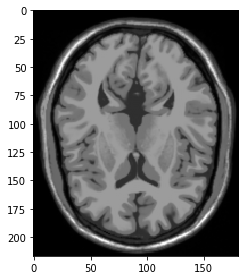

In [5]:
# Lets print a t1 image
t1_image_paths = glob.glob(t1_images_path)
io.imshow(str(t1_image_paths[0]))
print("T1 image")

T2 image


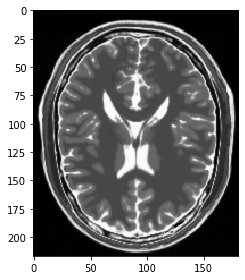

In [6]:
# Lets print a t2 image
t2_image_paths =glob.glob(t2_images_path)
io.imshow(str(t2_image_paths[0]))
print("T2 image")

In [7]:
# reading all images
from PIL import Image
t1_images= np.array([np.array(Image.open(fname)) for fname in tqdm.tqdm(t1_image_paths)])
t2_images = np.array([np.array(Image.open(fname)) for fname in tqdm.tqdm(t2_image_paths)])

100%|██████████| 46/46 [00:00<00:00, 480.15it/s]


In [8]:
# Normalizing images to [-1,1] to aid in computation. 
t1_images = (t1_images/127.5)-1.0
print(t1_images.shape)
t2_images = (t2_images/127.5)-1.0
print(t2_images.shape)

(43, 217, 181)
(46, 217, 181)


In [9]:
# training parameters
# as explained in the cycle gan paper https://arxiv.org/pdf/1703.10593.pdf batch_size of 1 produced good results
BATCH_SIZE = 4
# since the images are related to medical domain, higher image size is choosen for clarity. 
img_size = 512

#resizing the images
t1_data = np.zeros((t1_images.shape[0], img_size, img_size))
for index, img in enumerate(t1_images):
    t1_data[index, :, :] = resize(img, (img_size, img_size))
print(t1_data.shape)

t2_data = np.zeros((t2_images.shape[0], img_size, img_size))
for index, img in enumerate(t2_images):
    t2_data[index, :, :] = resize(img, (img_size, img_size))
print(t2_data.shape)

t1_data = t1_data.reshape(t1_data.shape[0], img_size, img_size, 1).astype('float32')
t2_data = t2_data.reshape(t2_data.shape[0], img_size, img_size, 1).astype('float32')

t1_data = tf.data.Dataset.from_tensor_slices(t1_data).shuffle(t1_images.shape[0], seed=42).batch(BATCH_SIZE)
t2_data = tf.data.Dataset.from_tensor_slices(t2_data).shuffle(t2_images.shape[0], seed=42).batch(BATCH_SIZE)

(43, 512, 512)
(46, 512, 512)


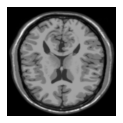

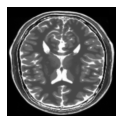

In [10]:
def print_sample(dataset):
  sample_data = next(iter(dataset))
  plt.figure(figsize=(2, 2))
  plt.imshow(sample_data[0].numpy()[:, :, 0], cmap='gray')
  plt.axis('off')
  plt.show()
print_sample(t1_data)
print_sample(t2_data)

## Re-usable functions. 

In [11]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [12]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [14]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 256, 256, 64)
        downsample(128, 4), # (bs, 128, 128, 128)
        downsample(128, 4), # (bs, 64, 8, 128)
        downsample(128, 4), # (bs, 32, 32, 128)
        downsample(128, 4), # (bs, 16, 16, 128)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 4, 2, 256)
        upsample(128, 4, True), # (bs, 8, 2, 256)
        upsample(128, 4, True), # (bs, 16, 2, 256)
        upsample(128, 4, True), # (bs, 32, 2, 256)
        upsample(128, 4, True), # (bs, 64, 2, 256)
        upsample(128, 4, True), # (bs, 128, 2, 256)
        upsample(128, 4, True), # (bs, 256, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,  activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[img_size, img_size, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

## Genertor G & F 

*   G converts T1 -> T2
*   F converts T2 -> T1




In [15]:
generator_g = unet_generator()
generator_f = unet_generator()

In [16]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 64) 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 128 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 128)  262400      sequential_1[0][0]               
______________________________________________________________________________________________

In [17]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.02)

    # image size is defined above. 
    inp = tf.keras.layers.Input(shape=[img_size, img_size, 1], name='input_image')

    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(128, 4)(down2) 
    down4 = downsample(128, 4)(down3) 
    down5 = downsample(128, 4)(down4) 
    down6 = downsample(128, 4)(down5) 
    
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down6) 
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) 

    norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

## Discrimnator X and Y

*   Discriminator X validates T1 Images
*   Discriminator Y validates T2 images.

In [18]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [19]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 512, 512, 1)]     0         
_________________________________________________________________
sequential_36 (Sequential)   (None, 256, 256, 64)      1024      
_________________________________________________________________
sequential_37 (Sequential)   (None, 128, 128, 128)     131328    
_________________________________________________________________
sequential_38 (Sequential)   (None, 64, 64, 128)       262400    
_________________________________________________________________
sequential_39 (Sequential)   (None, 32, 32, 128)       262400    
_________________________________________________________________
sequential_40 (Sequential)   (None, 16, 16, 128)       262400    
_________________________________________________________________
sequential_41 (Sequential)   (None, 8, 8, 128)         2624

## Loss Functions

In [20]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [22]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [23]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [24]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 5 * loss

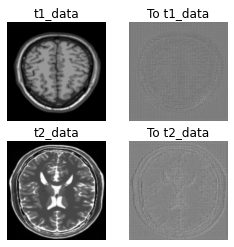

In [25]:
sample_t1_data = next(iter(t1_data))
sample_t2_data = next(iter(t2_data))
to_t1_data = generator_g(sample_t1_data)
to_t2_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t1_data, sample_t2_data, to_t2_data]
title = ['t1_data', 'To t1_data', 't2_data', 'To t2_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
# Setting the path for saving the model.

%cd /content/drive/MyDrive/ml_projects/style-transfer-using-gans

/content/drive/MyDrive/ml_projects/style-transfer-using-gans


In [28]:
# deleting saved model and images if any. 
!rm -r ./Trained_Model
!rm -r *.png

## Orchestration of training steps

In [29]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [30]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(24, 12))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    images = []
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        img = plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        images.append(img)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [31]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = (calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y))
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # tf.print(disc_fake_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return (total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss, total_cycle_loss)

## Training

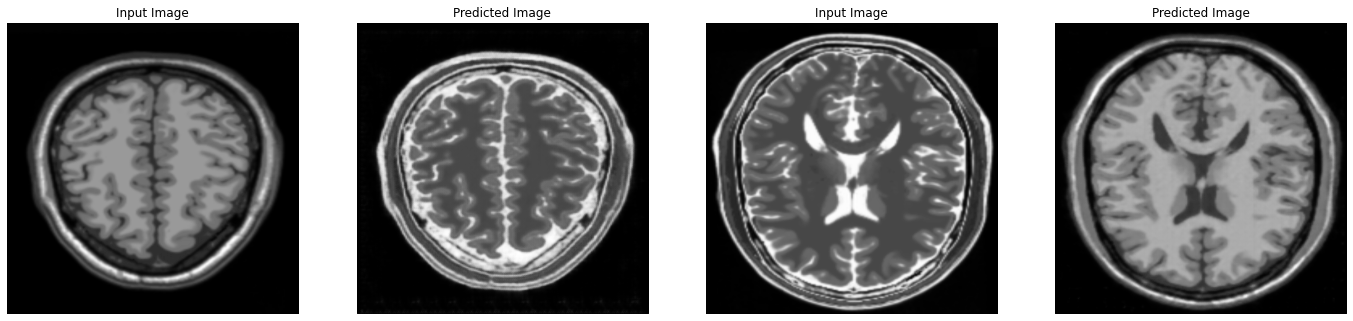

100%|██████████| 250/250 [37:56<00:00,  9.11s/it]


In [32]:
# ETA : 45 minutes approx on Google Colab Pro. 

EPOCHS = 250

eval_metrics = []

for epoch in tqdm.tqdm(range(1, EPOCHS+1)):
    
    for image_x, image_y in tf.data.Dataset.zip((t1_data, t2_data)):
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss, cycle_loss = train_step(image_x, image_y)
    
    # for higher file size 512*512 px the notebook crashes due to high memory usage hence clearing the prev output. 
    # the images are saved to disk to analyze the progress. 
    clear_output(wait=True)
    
    # save every few epochs
    if epoch % 20 == 0:
      ckpt_save_path = ckpt_manager.save()
      print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)
    
    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data)
    
    eval_metrics.append({"total_gen_g_loss": total_gen_g_loss.numpy(), "total_gen_f_loss": total_gen_f_loss.numpy(), "disc_x_loss": disc_x_loss.numpy(), 
                         "disc_y_loss": disc_y_loss.numpy(), 'cycle_loss': cycle_loss.numpy()})

## Evaluation



Below are some of the ways GANs can be evaluated. 
1. Visual Inspection. 
2. Fréchet inception distance

Note: The FID is calculated by running images through an Inception network. In practice, we compare the intermediate representations—feature maps or layers—rather than the final output (in other words, we embed them). More concretely, we evaluate the distance of the embedded means, the variances, and the covariances of the two distributions—the real and the generated one.

For this project FID cannot be used because 
1. Availability of pre-training inception model for T1/t2 brain images. 
2. Data Availability - min a 10k images are required (https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI)

Hence we will be using visual inspection for evaluating the results.

In [33]:
from PIL import Image

anim_file = 'cyclegan.gif'
frames = []

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in tqdm.tqdm(filenames):
      new_frame = Image.open(filename)
      frames.append(new_frame)

frames[0].save(anim_file, format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)

100%|██████████| 250/250 [00:00<00:00, 957.40it/s]


#### Visual Inspection. 


Due to the large size of the image (40mb), it cannot be embedded into the notebook. The below image shows how the network was able to learn the conversion process. The image can be downloaded from [here](https://drive.google.com/uc?id=14YT-0AWuoE86iIXypGOGk7PKjGt76UNp). If you run the notebook a file by name **cyclegan.gif** will be created in the current folder. 

As you may notice, through visual inspection it is clear that models are able to convert t1->t2 (1st and 2nd) and t2->t1 (3rd and 4th) images respectively.
This proves that the latent space is learnt by the models F & G which can now be used independently to generate t2/t1 images. 

Iterating the use cases  
- Reduce the cost of MRI scans for different types of images. T2-weighted / T1-weighted, the cost reduction ranges from 5k - 20k as explained above. 
- the images can be used to improve the classification accuracies of existing models by producing more synthetic data which are of higher quality and varied than regular data augmentation techniques.

<img src="https://drive.google.com/uc?id=14YT-0AWuoE86iIXypGOGk7PKjGt76UNp"/>

In [34]:
# converting metrics to dataframe.
import pandas as pd
import seaborn as sns
metrics = pd.DataFrame.from_records([m for m in eval_metrics])
metrics.head(10)

,total_gen_g_loss,total_gen_f_loss,disc_x_loss,disc_y_loss,cycle_loss
0,7.618545,7.428601,0.258973,0.204311,4.594825
1,7.412998,5.886607,0.111983,0.225953,2.957226
2,7.271550,6.257318,0.228037,0.106364,3.555298
3,8.336096,5.071676,0.913889,0.539357,3.171474
4,5.951184,5.303513,0.234439,0.404618,2.785472
5,6.156705,5.750748,0.219267,0.299129,2.753187
6,6.892105,5.498325,0.238133,0.197413,2.797828
7,6.738119,4.338966,0.501587,0.395069,2.686803
8,4.885108,6.997992,0.616121,0.423181,2.738707
9,5.408901,4.663429,0.418497,0.406242,2.847445


In [35]:
def draw_metrics_chart(cols, title, ytitle):
  sns.set_style("darkgrid")
  plt.figure(figsize=(12,4))
  ax = sns.lineplot(data=metrics[cols])
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(ytitle)
  plt.show()


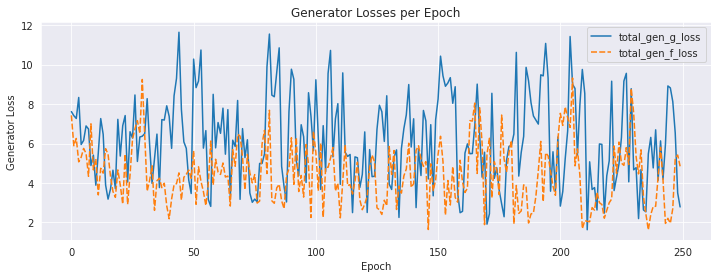

In [36]:
draw_metrics_chart(['total_gen_g_loss', 'total_gen_f_loss'], "Generator Losses per Epoch", "Generator Loss")

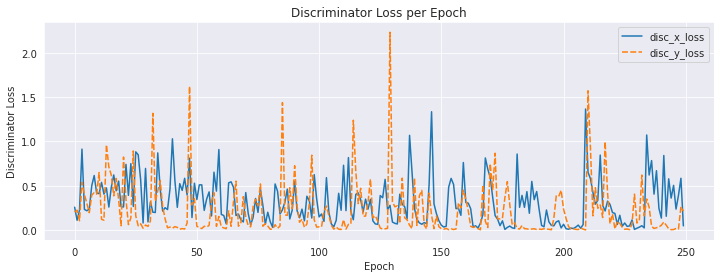

In [37]:
draw_metrics_chart(['disc_x_loss', 'disc_y_loss'], "Discriminator Loss per Epoch", "Discriminator Loss")

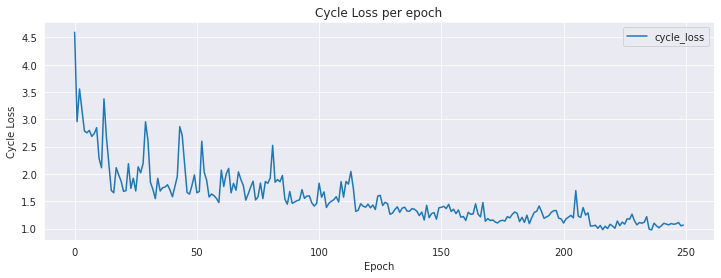

In [38]:
draw_metrics_chart(['cycle_loss'], "Cycle Loss per epoch", "Cycle Loss")

### Summary
- Although the graphs alone are not reliable we can notice the loss coming down per epoch. 
- Through visual inspection it is clear that the images are converted to alternate domain correctly. 
- Further the evaluation can be improved if we can calculate the Frenchet Inception score using a pre-training inception model which is good at classifying T1/T2 Brain MRI images. 